# World CO2 Emissions Forecasting
## LSTM Model
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- Forecast the amount of World CO2 emissions (in tonnes) for the next 10 years (2021 - 2030).


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import plotly.express as px
import math
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['axes.grid'] = False

# Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


In [4]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664
df['co2'] = df['co2']/3.664
df.tail().round(1)

,date,co2
266,2016-12-31,34035.4
267,2017-12-31,34471.8
268,2018-12-31,35058.0
269,2019-12-31,35049.9
270,2020-12-31,33185.8


In [5]:
# Visualizing the yearly emissions
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True, 
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show()

## Windowing Function

In [6]:
def df_to_inputs(df, window_size = 5):
    # Input: dataframe with the time series and window size
    # Windows size refers to the number of points in the series with which the model will be trained
    # Output: X, y for training
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        X.append([[a] for a in df_as_np[i:i+5]])
        y.append(df_as_np[i+5])
    return np.array(X), np.array(y)

In [7]:
# Getting the windows
WINDOW_SIZE = 5
X, y = df_to_inputs(df['co2'], WINDOW_SIZE)

In [8]:
X.shape, y.shape

((266, 5, 1), (266,))

In [9]:
X[1:3]

array([[[12.7606441 ],
        [12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502]],

       [[12.76473799],
        [12.76473799],
        [12.77019651],
        [12.77565502],
        [13.65447598]]])

## Scaling and Splitting for Train, Validation and Test Sets

In [10]:
# 85% Train, 7.5% Valid, 7.5% Test
print(f'80% of samples for Training: {math.ceil(0.85*266)} samples')
print(f'7.5% of samples for Validating: {math.ceil(0.075*266)} samples')
print(f'7.5% of samples for Testing: {math.ceil(0.075*266)} samples')

80% of samples for Training: 227 samples
7.5% of samples for Validating: 20 samples
7.5% of samples for Testing: 20 samples


In [11]:
# 85% Train, 7.5% Valid, 7.5% Test
# X_train, y_train = X[:227], y[:227]
# X_val, y_val = X[227:247], y[227:247]
# X_test, y_test = X[247:], y[247:]

df_train = df[:247]
df_test = df[247:]

In [12]:
# Scaling the Data
df_train_scaled = df_train
df_test_scaled = df_test

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(df_train['co2'].values.reshape(-1,1))
df_train_scaled['co2'] = scaler.transform(df_train['co2'].values.reshape(-1,1))
df_test_scaled['co2'] = scaler.transform(df_test['co2'].values.reshape(-1,1))

In [13]:
# Windowing
WINDOW_SIZE = 5

X_train, y_train = df_to_inputs(df_train_scaled['co2'], WINDOW_SIZE)
X_test, y_test = df_to_inputs(df_test_scaled['co2'], WINDOW_SIZE)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 5, 1), (242,), (19, 5, 1), (19,))

In [15]:
X_train[1:3]

array([[[0.00000000e+00],
        [1.66839395e-07],
        [1.66839395e-07],
        [3.89291923e-07],
        [6.11744450e-07]],

       [[1.66839395e-07],
        [1.66839395e-07],
        [3.89291923e-07],
        [6.11744450e-07],
        [3.64266013e-05]]])

In [16]:
X_train[1].shape

(5, 1)

## Building the LSTM Model

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

2022-09-26 22:54:49.550952: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 22:54:49.553118: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, batch_size = 32, epochs = 30)

Train on 242 samples
Epoch 1/30


2022-09-26 22:56:25.764119: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_9856_10341' and '__inference___backward_standard_lstm_9856_10341_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_10982' both implement 'lstm_34696229-27c3-417f-9f06-dd4b22361de0' but their signatures do not match.


242/242 [==============================] - 4s 15ms/sample - loss: 9.4596e-04
Epoch 2/30
242/242 [==============================] - 0s 865us/sample - loss: 5.0245e-04
Epoch 3/30
242/242 [==============================] - 0s 855us/sample - loss: 3.3998e-04
Epoch 4/30
242/242 [==============================] - 0s 823us/sample - loss: 3.6720e-04
Epoch 5/30
242/242 [==============================] - 0s 844us/sample - loss: 4.0072e-04
Epoch 6/30
242/242 [==============================] - 0s 880us/sample - loss: 3.8725e-04
Epoch 7/30
242/242 [==============================] - 0s 874us/sample - loss: 3.0819e-04
Epoch 8/30
242/242 [==============================] - 0s 887us/sample - loss: 2.7789e-04
Epoch 9/30
242/242 [==============================] - 0s 819us/sample - loss: 3.3769e-04
Epoch 10/30
242/242 [==============================] - 0s 885us/sample - loss: 3.4698e-04
Epoch 11/30
242/242 [==============================] - 0s 822us/sample - loss: 3.1299e-04
Epoch 12/30
242/242 [==========

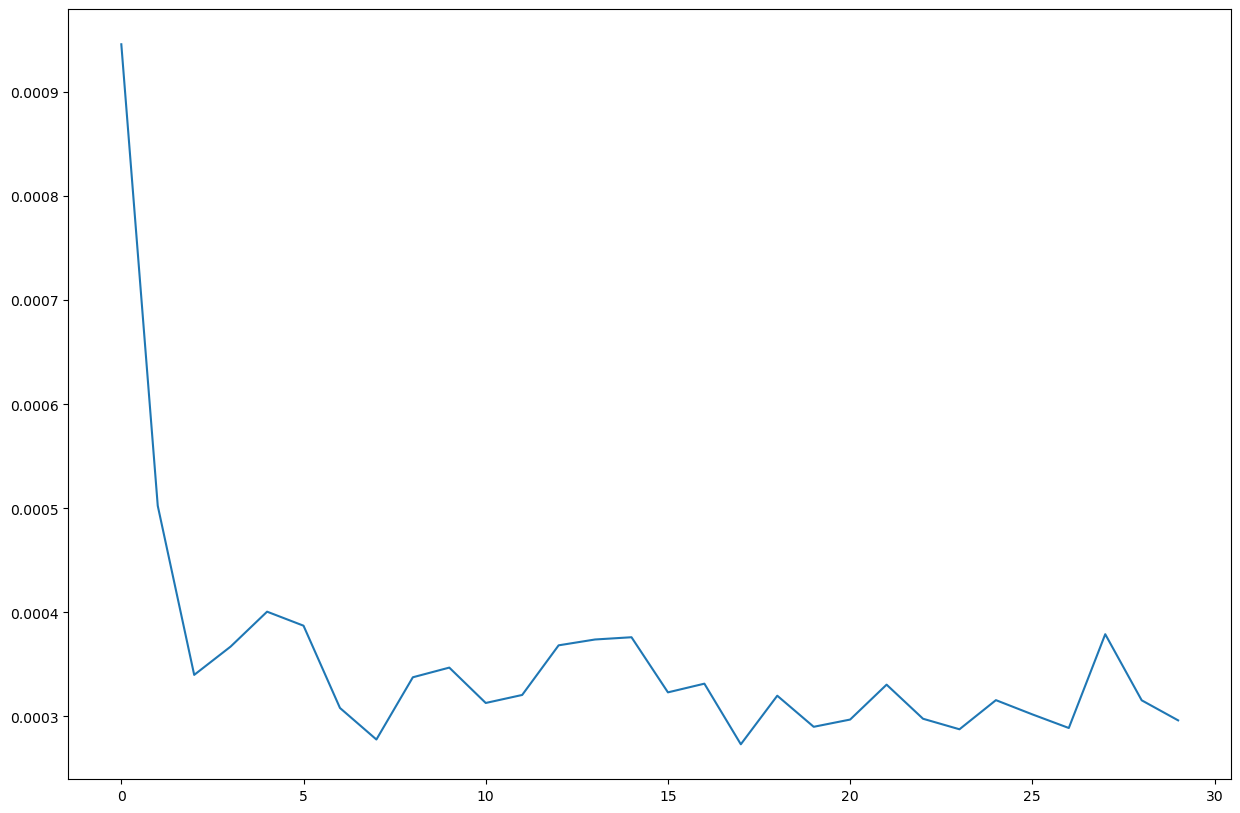

In [22]:
plt.plot(history.history['loss'])
plt.show()